In [51]:
%load_ext autoreload
%autoreload 2
from src.util import utilities as util
from src.data import make_dataset as md

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Notebooks can't display cv2 images natively, so we use this function to display them inline instead of cv2.imshow()
import io
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

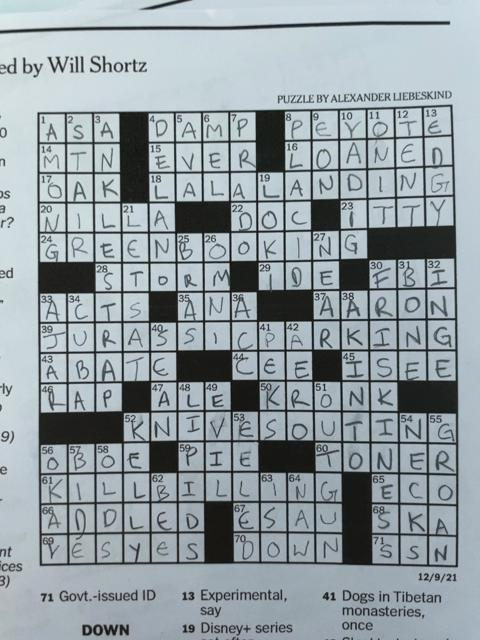

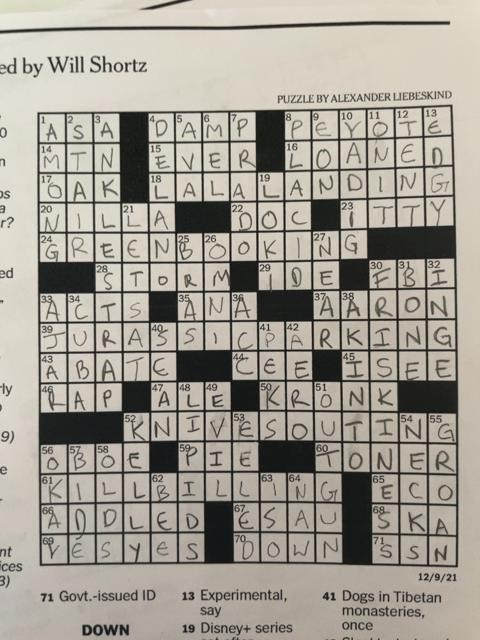

In [53]:
import cv2
import numpy as np

image = cv2.imread("../data/raw/image_uploads/2021-12-09-19d31d74-1cdd-40bc-9e6d-8ebd3713fb17.png")

# cv2 color channels are ordered BGR instead of RGB by default. rearrange color channels if you want a normal looking image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

showarray(image)
showarray(rgb)



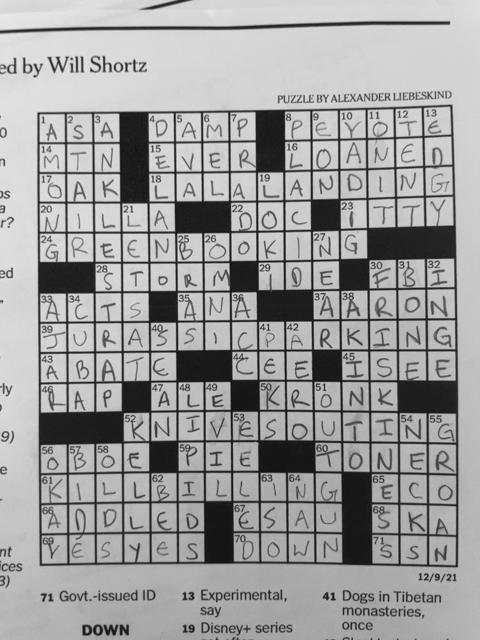

In [54]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
showarray(gray)


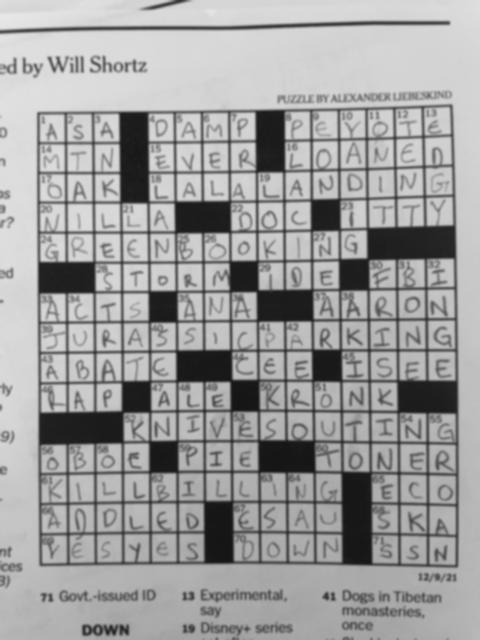

In [55]:
# blur the image to reduce noise
blur = cv2.GaussianBlur(gray, (5,5),0)
showarray(blur)

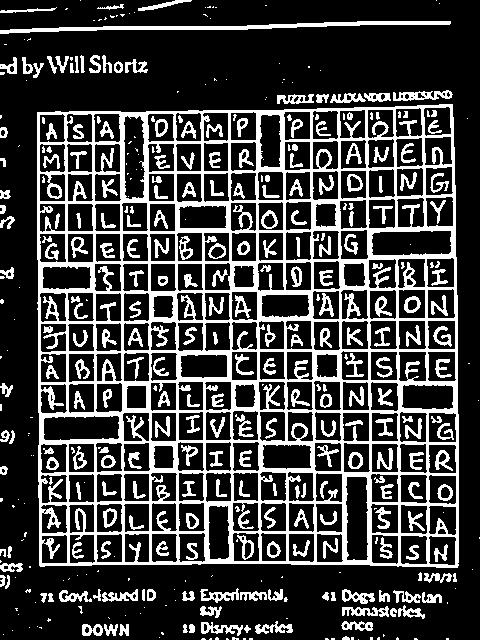

In [56]:
# apply thresholding to make everything black or white.  Adaptive thresholding is used to compensate for different lighting conditions across the image
thresh = cv2.adaptiveThreshold(blur,255,1,1,11,2)
showarray(thresh)

In [57]:
# find countours, the curves that joins all continuous points having the same color or intentsity
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

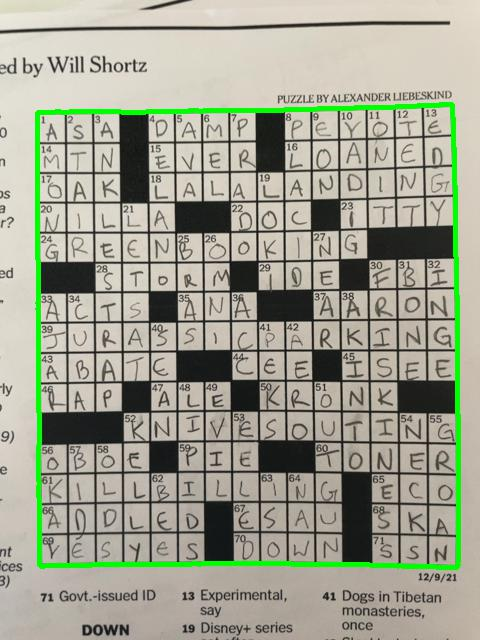

In [58]:
# we find the largest contour by area and assume this is the entire crossword grid
rgbcopy = rgb.copy()
max_area = 0
c = 0
for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
                if area > max_area:
                    max_area = area
                    best_cnt = i
                    rgb_c = cv2.drawContours(rgbcopy, contours, c, (0, 255, 0), 3)
                    
        c+=1
showarray(rgb_c)


In [59]:
from src.data import image_proccessor as ip
# find the corners of the image
peri = cv2.arcLength(best_cnt, True)
corners = cv2.approxPolyDP(best_cnt, 0.04 * peri, True)
corners

# All points are in format [cols, rows]
im_pr = ip.ImageProcessor(None)
pt_A, pt_B, pt_C, pt_D = im_pr._ImageProcessor__order_corners(corners) # TODO: Bad pattern, refactor 



In [60]:
# Calculate widths/heights using L2 norm
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

In [61]:
# map input points and output points after warping
input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

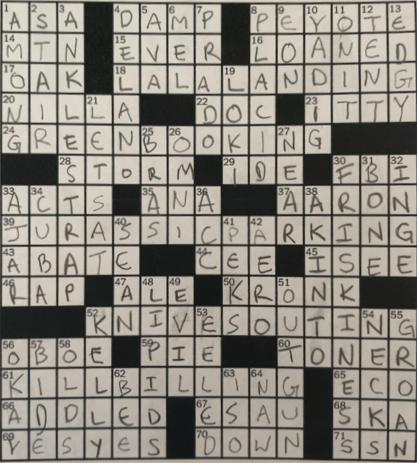

In [62]:
# Compute the perspective transform M
rgbcopy = rgb.copy()
M = cv2.getPerspectiveTransform(input_pts,output_pts)
warped = cv2.warpPerspective(rgbcopy,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
showarray(warped)

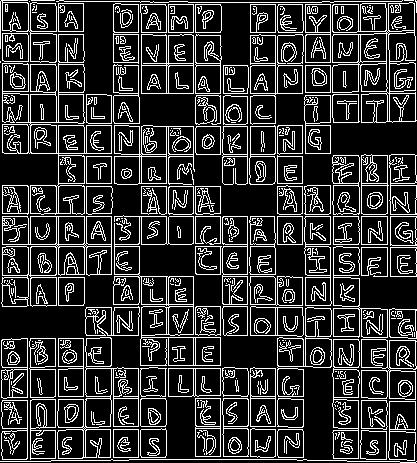

In [63]:
# find Canny edges
edges = cv2.Canny(warped, 50, 200)
showarray(edges)

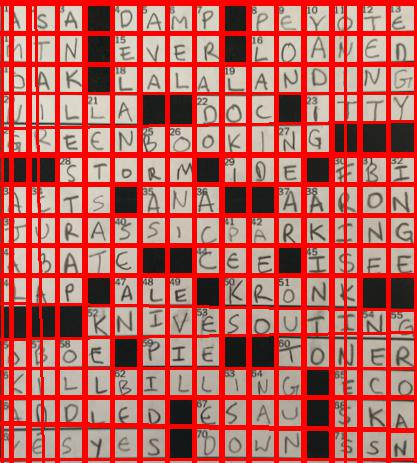

In [64]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 130, None, 5, 5000)
lined = warped.copy()
hlines = []
vlines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    # filter out non-vertical  and non horizontal lines
    angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi)

    # Draw horizontal lines, forcing them to start at 0 and be the max image width
    if (angle >=0 and angle <= 1) :
        cv2.line(lined, (0, y1), (maxWidth, y2), (255, 0, 0), 2)
        hlines.append([0,y1,maxWidth,y2])
    # Draw vertical lines, forcing them to start at 0 and be the max image height
    if (angle >= 88 and angle <= 92):
        cv2.line(lined, (x1, 0), (x2, maxHeight), (255, 0, 0), 2)
        vlines.append([x1,0,x2,maxHeight])

showarray(lined)

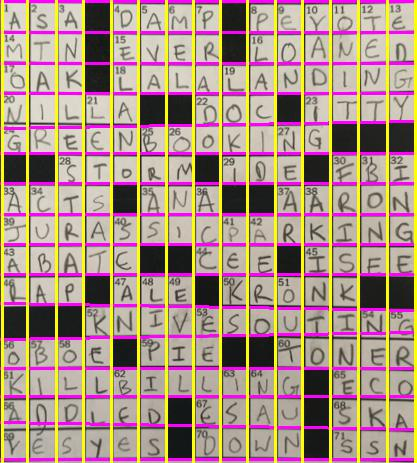

In [66]:
# find unique lines and draw those on the image

lined_unique = warped.copy()

hlines.sort(key=lambda x:x[1])
hlines_unique = []
previous_line_y1 = -1000
for line in hlines:
    if line[1] >= previous_line_y1+20: # TODO: instead of skipping the duplicate lines, average the duplicate line's coordinates with the original to get a better fit
        hlines_unique.append(line)
        previous_line_y1 = line[1]
        cv2.line(lined_unique, (line[0], line[1]), (line[2], line[3]), (255, 0, 255), 2)

vlines.sort(key=lambda x:x[0])
vlines_unique = []
previous_line_x1 = -1000
for line in vlines:
    if line[0] >= previous_line_x1+20:
        vlines_unique.append(line)
        previous_line_x1 = line[0]
        cv2.line(lined_unique, (line[0], line[1]), (line[2], line[3]), (255, 255, 0), 2)

showarray(lined_unique)



In [576]:
# crop image based on line intersections
img = warped.copy()
prev_hline = hlines_unique[0]
prev_vline = vlines_unique[0]

for hline in hlines_unique[1:]:
    for vline in vlines_unique[1:]:
        y=prev_hline[1]
        yheight=hline[1]
        x=prev_vline[0]
        xwidth=vline[0]
        cropped = img[y:yheight,x:xwidth].copy()

        prev_vline=vline
        #print("v:",y,yheight,x,xwidth)
        showarray(cropped)
    
    prev_vline=vlines_unique[0]
    prev_hline=hline
    #print("h:",y,yheight,x,xwidth)
